<a href="https://colab.research.google.com/github/kirubanath/computer-vision/blob/main/Image_Stiching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>
  <h1 align="center"> Constructing Image Panaroma </h1>
</b>

<p align = "center">
  <b>Aditya Pandey, Kirubananth Sankar</b> 
</p>

**Steps:**
```
1. Detecting Keypoints and extracting local invariant feature descriptors from the two input images using SIFT Algorithm.
2. Matching the descriptors betwen the two images.
3. Using RANSAC algorithm to estimate the HOMOGRAPHY matrix.
4. Appling warping tranformation using the matrix obtained above and stiching the images together.

```

**Importing Necessary Libraries**

In [149]:
import cv2
import gdown
import numpy as np
import matplotlib.pyplot as plt
import os

**Reading the images**

In [156]:
query = cv2.imread("/content/query.jpg")
query= cv2.cvtColor(query,cv2.COLOR_BGR2RGB)

train = cv2.imread("/content/train.jpg")
train= cv2.cvtColor(train,cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'Train Image')

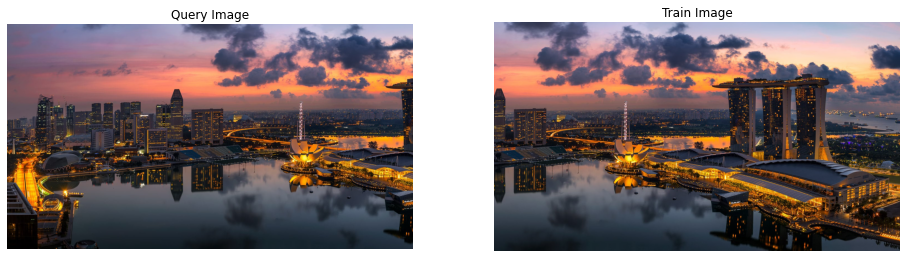

In [162]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(query)
ax[0].axis("off")
ax[0].set_title("Query Image")

ax[1].imshow(train)
ax[1].axis("off");
ax[1].set_title("Train Image")

**Converting the images to greyscale**

In [158]:
query_grey = cv2.cvtColor(query,cv2.COLOR_RGB2GRAY)
train_grey = cv2.cvtColor(train,cv2.COLOR_RGB2GRAY)

Text(0.5, 1.0, 'Train Image')

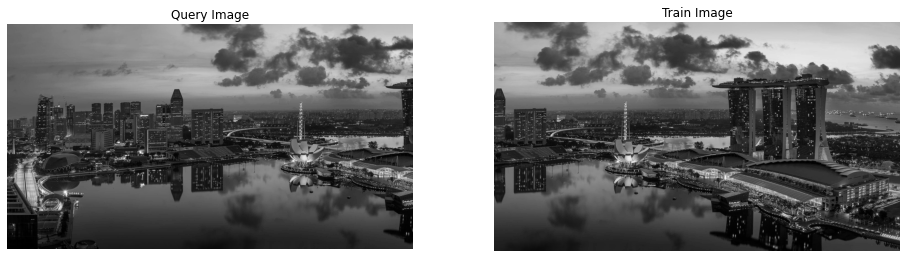

In [165]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(query_grey, cmap = "gray")
ax[0].axis("off")
ax[0].set_title("Query Image")

ax[1].imshow(train_grey, cmap = "gray")
ax[1].axis("off");
ax[1].set_title("Train Image")

**Calculating the SIFT keypoints and descriptors**

In [166]:
sift = cv2.xfeatures2d.SIFT_create()
kp_query, des_query = sift.detectAndCompute(query_grey,None)
kp_train, des_train = sift.detectAndCompute(train_grey,None)

**Visualizing the keypoints**

In [168]:
query_kp = cv2.drawKeypoints(query_grey,kp_query,query_grey, color = (255,0,0))
train_kp = cv2.drawKeypoints(train_grey,kp_train,train_grey, color = (255,0,0))

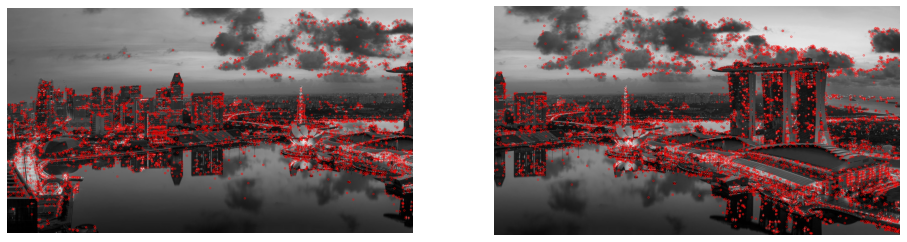

In [170]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(query_kp)
ax[0].axis("off")
ax[1].imshow(train_kp)
ax[1].axis("off");


**Matching the keypoints:**


In [180]:
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des_train, des_query, k=2)

**Weeding out the batch matches using the ratio of best match vs next best match**

In [181]:
good = []
for m,n in matches:
    if (m.distance < 0.75*n.distance):
        good.append(m)
matches = np.asarray(good)

**Vizualing the matches**

(-0.5, 2921.5, 818.5, -0.5)

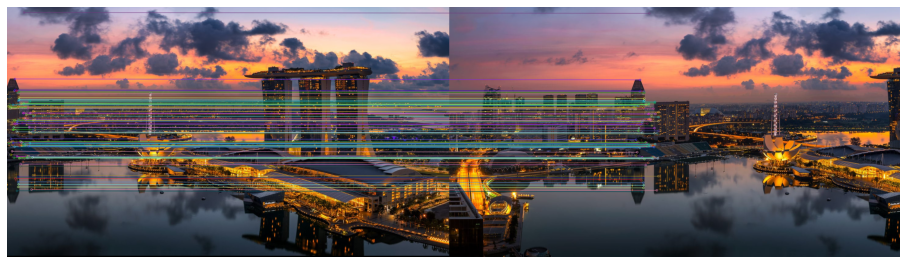

In [184]:
matched_image = cv2.drawMatches(train,kp_train,query,kp_query,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize= (16,8))
plt.imshow(matched_image)
plt.axis("off")

**We can see the best matches above and its mostly at the correct places**

**Calculationg the homography matrix:**
```
Two images of a scene are said to be related by a homography under two conditions:

1.The two images are that of a plane e.g. sheet of paper, credit card etc.
2.The two images were acquired by rotating the camera about its optical axis.
```

In [189]:
def homo_matrix(matches,kp_train= kp_train,kp_query= kp_query):
  """
  Using the matched keypoints creates a homography matrix
  """
  kp_train = np.float32([keypoint.pt for keypoint in kp_train])
  kp_query = np.float32([keypoint.pt for keypoint in kp_query])

  if (len(matches) >= 4):
    points_train = np.float32([kp_train[m.queryIdx] for m in matches])
    points_query = np.float32([kp_query[m.trainIdx] for m in matches])
    (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, 4)
    return (matches, H, status)

  else:
      raise AssertionError('Can’t find enough keypoints.')

In [191]:
matches, H, status= homo_matrix(matches)

In [193]:
print(H)

[[ 1.00009702e+00 -5.51891591e-05  5.99010189e+02]
 [ 4.50017068e-05  1.00004826e+00  2.96539254e+00]
 [ 8.38538379e-08 -3.63625524e-08  1.00000000e+00]]


**Using the homography matrix to warp the images and stich them together**

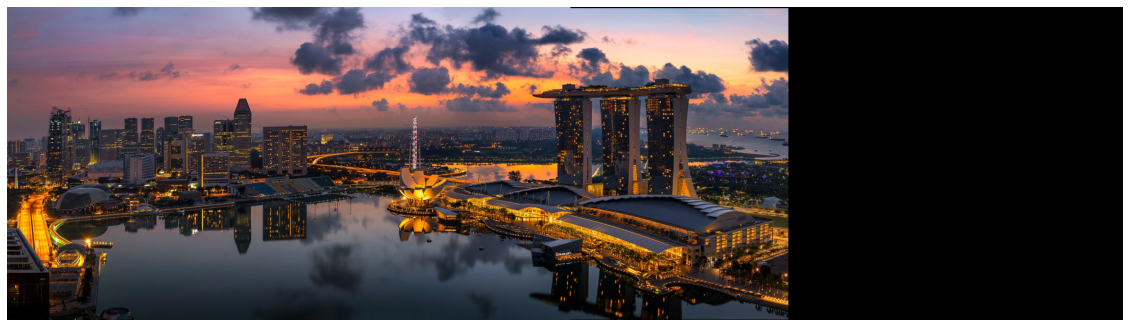

In [205]:
width = query.shape[1] + train.shape[1]
height = max(query.shape[0], train.shape[0])

stiched_image = cv2.warpPerspective(train, H,  (width, height))
stiched_image[0:query.shape[0],0:query.shape[1]] = query

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(stiched_image);

**Putting together all of this into a function**

In [212]:
def stich(query_path, train_path):
  #downloading the images:
  query = cv2.imread(query_path)
  query= cv2.cvtColor(query,cv2.COLOR_BGR2RGB)

  train = cv2.imread(train_path)
  train= cv2.cvtColor(train,cv2.COLOR_BGR2RGB)

  #plotting the input images:
  fig,ax = plt.subplots(1,2,figsize=(16,8))
  ax[0].imshow(query)
  ax[0].axis("off")
  ax[0].set_title("Query Image")

  ax[1].imshow(train)
  ax[1].axis("off");
  ax[1].set_title("Train Image")

  #converting to gray scale:
  query_grey = cv2.cvtColor(query,cv2.COLOR_RGB2GRAY)
  train_grey = cv2.cvtColor(train,cv2.COLOR_RGB2GRAY)

  #SIFT keypoints and descriptors:
  sift = cv2.xfeatures2d.SIFT_create()
  kp_query, des_query = sift.detectAndCompute(query_grey,None)
  kp_train, des_train = sift.detectAndCompute(train_grey,None)

  #matching the keypoints:
  bf = cv2.BFMatcher(cv2.NORM_L2)
  matches = bf.knnMatch(des_train, des_query, k=2)
  good = []
  for m,n in matches:
      if (m.distance < 0.75*n.distance):
          good.append(m)
  matches = np.asarray(good)

  #Homography matrix:
  kp_train = np.float32([keypoint.pt for keypoint in kp_train])
  kp_query = np.float32([keypoint.pt for keypoint in kp_query])

  if (len(matches) >= 4):
    points_train = np.float32([kp_train[m.queryIdx] for m in matches])
    points_query = np.float32([kp_query[m.trainIdx] for m in matches])
    (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, 4)

  else:
      raise AssertionError('Can’t find enough keypoints.')

  #sticthing the images using homography matrix:
  width = query.shape[1] + train.shape[1]
  height = max(query.shape[0], train.shape[0])

  stiched_image = cv2.warpPerspective(train, H,  (width, height))
  stiched_image[0:query.shape[0],0:query.shape[1]] = query

  #output:
  fig = plt.figure(figsize = (16,8))
  plt.imshow(stiched_image)
  plt.axis("off")
  plt.title("Stitched Image")

  return stiched_image

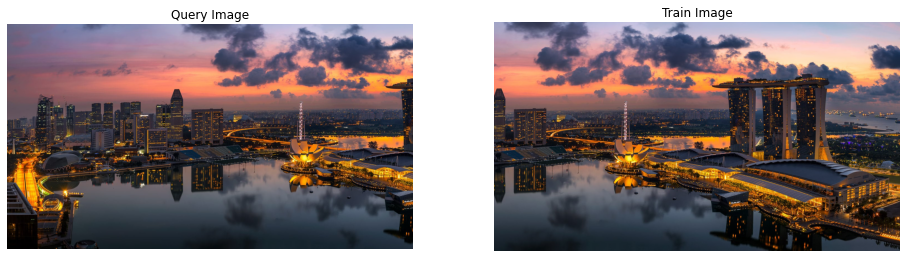

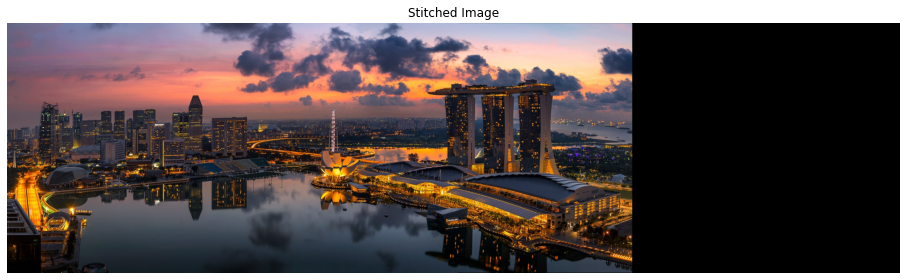

In [217]:
query_path = "/content/query.jpg"
train_path = "/content/train.jpg"
test1 = stich(query_path, train_path)

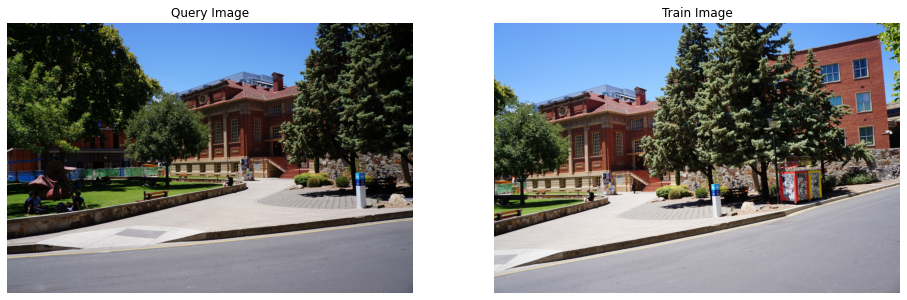

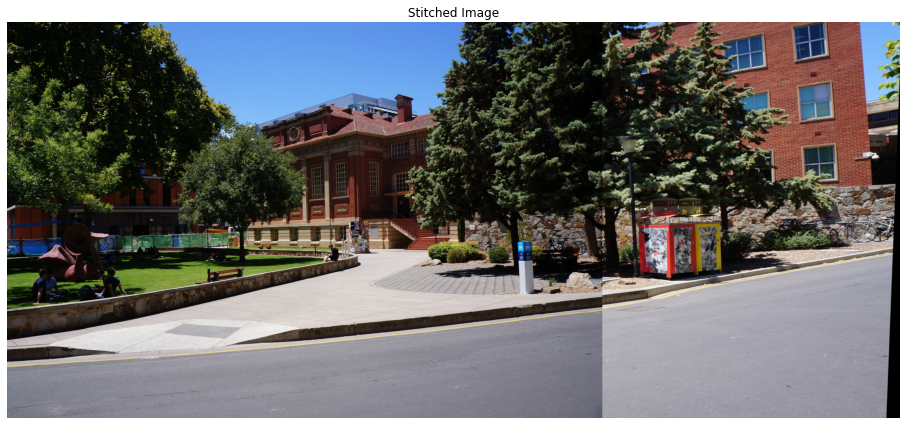

In [220]:
query_path = "/content/DSC02930.JPG"
train_path = "/content/DSC02931.JPG"
test2 = stich(query_path, train_path)